In [43]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from dnn_model import DNN_model
from network_functions import train_loop, eval_loop, test_loop, evaluate_predictions


f0 = 25e9   # carrier frequency
k = 2*np.pi / (3e8 / f0) # wave number
d = 3e8/f0 / 2
N = 128     # antennas
N_RF = 8   # RF chains
SNR_dB = list(range(0,25,5))
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]

r_lim = [1, 20] # near-field range limits [m]

#---------- training parameters -----------
dataset_size = 10000
generate_dataset = 0
epochs = 100
batch_size = 64
lr = 1e-2
train_val_split = 0.7
val_split = 0.2
test_split = 0.1
dataset_root = 'dataset/'
dataset_path = os.path.join(dataset_root,'dataset.npy')
models = [DNN_model]
rng_seed = 42
#------------------------------------------

#%% Data Prep

if generate_dataset:
    def CN_realization(mean, std_dev, size=1):
        return np.random.normal(mean, std_dev, size) + 1j * np.random.normal(mean, std_dev, size)


    delta = lambda n: (2*n - N + 1)/2

    # near-field array response vector (parabolic wavefront approximation)
    a = lambda theta, r: np.array([np.exp(-1j*k*(np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) - r)) for n in range(N)]).T

    dataset = dict()


    np.random.seed(rng_seed)
    ii = 0
    for i in range(dataset_size):
        for snr in SNR:
            sigma_n = 1 / np.sqrt(snr)
            s = CN_realization(mean=0, std_dev=1)
            n = CN_realization(mean=0, std_dev=sigma_n, size=N)
            
            r = np.random.uniform(r_min, r_max)
            r_norm = 2 * (r - r_min) / (r_max - r_min) - 1
            theta = np.random.uniform(-1,1)
            
            # uplink received signal
            y_ = a(theta,r) * s + n
            y = np.concatenate((y_.real, y_.imag))
            
            datapoint = {
                'SNR': snr,
                'X': y,
                'y': np.array([theta, r_norm])
            }
            
            dataset[ii] = datapoint
            ii += 1

    if not os.path.exists(dataset_root):
        os.makedirs(dataset_root)

    np.save(dataset_path,dataset,allow_pickle=True)
    print(f"Dataset saved to {dataset_path}")
    print(len(dataset))

# Load Data
dataset = np.load(dataset_path,allow_pickle=True).item()
print("Dataset loaded successfully.")




Dataset loaded successfully.


In [3]:
import pandas as pd
df = pd.read_csv('saved_models/fully-connected_50epochs_64batch_model0_lr0.01_provoasalvareirisultati/best_rmse_epoch.csv')

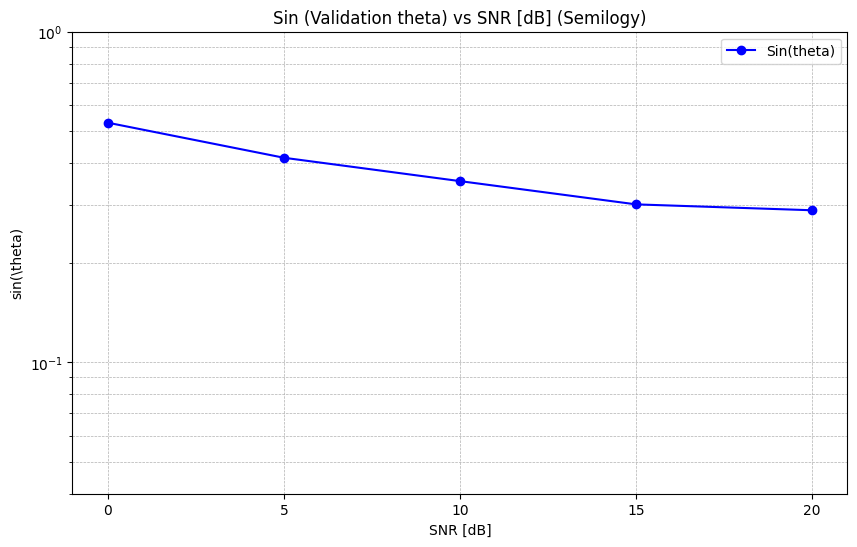

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the sine of 'Val (theta)'
df['Sin (Val theta)'] = np.sin(np.deg2rad(df['Val (theta)']))

# Plotting 'Sin (Val theta)' with a semilogy axis
plt.figure(figsize=(10, 6))
plt.plot(df['SNR [dB]'], df['Sin (Val theta)'], 'o-b', label='Sin(theta)')
# plt.plot(df['SNR [dB]'],df['Val (theta)'], 'd--g', label='theta')
plt.xlabel('SNR [dB]')
plt.ylabel(r'sin(\theta)')
# plt.rcParams['text.usetex'] = False
plt.title('Sin (Validation theta) vs SNR [dB] (Semilogy)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.yscale('log')
plt.xticks(SNR_dB)
plt.ylim([0.4e-1,1])
plt.legend()
plt.yscale('log')
plt.show()


Example of plotting for multiple curves with logaritmic y-axis

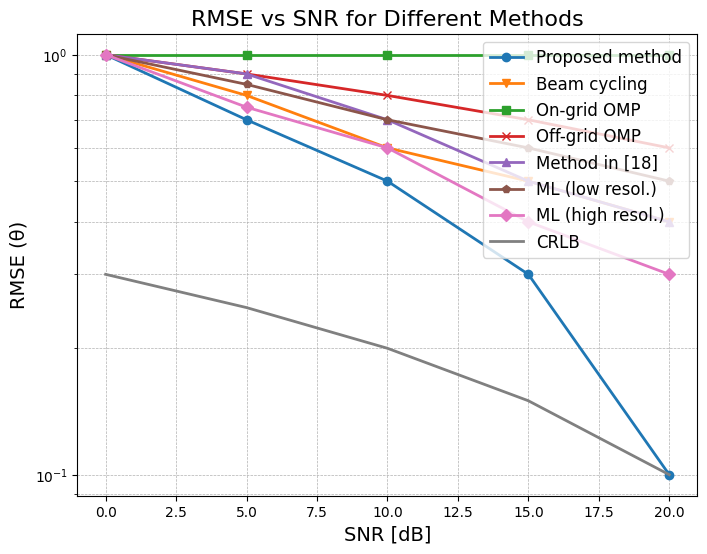

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# SNR values in dB
SNR = np.array([0, 5, 10, 15, 20])

# Root Mean Square Error (RMSE) values for different methods
proposed_method = np.array([1, 0.7, 0.5, 0.3, 0.1])
beam_cycling = np.array([1, 0.8, 0.6, 0.5, 0.4])
on_grid_omp = np.array([1, 1, 1, 1, 1])
off_grid_omp = np.array([1, 0.9, 0.8, 0.7, 0.6])
method_18 = np.array([1, 0.9, 0.7, 0.5, 0.4])
ml_low_resol = np.array([1, 0.85, 0.7, 0.6, 0.5])
ml_high_resol = np.array([1, 0.75, 0.6, 0.4, 0.3])
crlb = np.array([0.3, 0.25, 0.2, 0.15, 0.1])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(SNR, proposed_method, 'o-', label='Proposed method', linewidth=2)
plt.plot(SNR, beam_cycling, 'v-', label='Beam cycling', linewidth=2)
plt.plot(SNR, on_grid_omp, 's-', label='On-grid OMP', linewidth=2)
plt.plot(SNR, off_grid_omp, 'x-', label='Off-grid OMP', linewidth=2)
plt.plot(SNR, method_18, '^-', label='Method in [18]', linewidth=2)
plt.plot(SNR, ml_low_resol, 'p-', label='ML (low resol.)', linewidth=2)
plt.plot(SNR, ml_high_resol, 'D-', label='ML (high resol.)', linewidth=2)
plt.plot(SNR, crlb, '-', label='CRLB', linewidth=2, color='grey')

# Labels and title
plt.xlabel('SNR [dB]', fontsize=14)
plt.ylabel('RMSE (θ)', fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('RMSE vs SNR for Different Methods', fontsize=16)

# Show plot
plt.show()


In [108]:
train_val_split = 0.8
test_split = 0.1
train_dim = int(train_val_split*dataset_size*len(SNR))
test_dim = int(test_split*dataset_size*len(SNR))

X_train, y_train = np.array([dataset[i]['X'] for i in range(train_dim)]), np.array([dataset[i]['y'] for i in range(train_dim)])
X_val, y_val = np.array([dataset[i]['X'] for i in range(train_dim,train_dim+test_dim)]), np.array([dataset[i]['y'] for i in range(test_dim)])
X_test, y_test = np.array([dataset[i]['X'] for i in range(train_dim+test_dim,train_dim+test_dim*2)]), np.array([dataset[i]['y'] for i in range(test_dim)])

In [109]:
# PyTorch Tensors
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

#%% Training
data_type = 0
# Model Save Folder
folder_name = 'type%i_batchsize%i_rng%i_epoch%i' %(data_type, batch_size, rng_seed, epochs)
models_directory = os.path.abspath('./saved_models/')
if not os.path.exists(models_directory):
    os.makedirs(models_directory)
c = 0
while os.path.exists(os.path.join(models_directory, folder_name + '_v%i'%c, '')):
    c += 1
model_directory = os.path.join(models_directory, folder_name + '_v%i'%c, '')
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
print('Saving the models to %s' % models_directory)

Saving the models to c:\Users\asus\Desktop\Università\PhD\PhD\TIMES\DNN_localization\saved_models


## Normalize Network Training Weights
Apply constraint as in eq (5d).

In [199]:
class weightConstraint(object):
    def __init__(self,N=128,N_RF=8):
        self.N = N
        self.N_RF = N_RF
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            w = module.weight.data # shape (2*N_RF,2*N)
            w_rf = w[:self.N_RF,:self.N] + 1j*w[self.N_RF:self.N_RF*2,:self.N] # shape (N_RF,N)
            w[:self.N_RF,:self.N] = w[:self.N_RF,:self.N] / (np.abs(w_rf) * np.sqrt(self.N))
            w[self.N_RF:self.N_RF*2,:self.N] = w[self.N_RF:self.N_RF*2,:self.N] / (np.abs(w_rf) * np.sqrt(self.N))
            module.weight.data=w

# Reproducibility
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
torch.backends.cudnn.deterministic = True

# PyTorch GPU/CPU selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Neural network
model = models[0](N,N_RF)

# Applying the constraints to only the last layer
constraints=weightConstraint(N,N_RF)
model._modules['fc1'].apply(constraints)

# Training Settings
model.to(device)
criterion = torch.nn.MSELoss() # Training Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [197]:
# for param in model.parameters():
for name, param in model.named_parameters():
    if 'weight' in name and 'fc1' in name:
        w_in = param
        break
w_in = w_in.detach().numpy() # (16,256)
w_1_in = w_in[:N_RF,:N]
w_2_in = w_in[N_RF:2*N_RF,:N]

W_RF = w_1_in + 1j*w_2_in

# # normalize precoder to meet the power contraint for each antenna (1/N)
# W_RF = W_RF / (np.abs(W_RF) * np.sqrt(N))
# if I sum over all the RF-chains and N antennas, the abs() should return 1/N * N * N_RF = N_RF = 8
np.sum(np.abs(W_RF)**2) # should be equal to N_RF

8.0

In [260]:
from dnn_model import DNN_model

model = DNN_model(N,N_RF)
model_directory = 'saved_models/type0_batchsize64_rng42_epoch10_v0'
model.load_state_dict(torch.load(os.path.join(model_directory, 'model_final.pth')))

686.38776


<All keys matched successfully>

In [292]:
batch_y_pred = -torch.ones((4,2))
batch_y_pred[:,0] = 0.2
batch_y = torch.ones((4,2))
batch_y[:,0] = 0.2
batch_y[0,0] = 0.1
# print('network output\n', batch_y_pred, '\nlabel\n', batch_y)

def range_angle_from_net_output(y_pred,r_lim):
    r = r_lim[0] + (y_pred[:,0] + 1)/2 * (r_lim[1] - r_lim[0])
    angle_rad = torch.asin(y_pred[:,1])
    angle_deg = angle_rad * 180/torch.math.pi
    return [r, angle_rad, angle_deg]


def pol2cart(r,theta):
    x = r * torch.cos(torch.deg2rad(theta))
    y = r * torch.sin(torch.deg2rad(theta))
    pos = torch.stack((x, y), dim=1)
    return pos

[r_pred,_,theta_pred] = range_angle_from_net_output(batch_y_pred,r_lim)
[r,_,theta] = range_angle_from_net_output(batch_y,r_lim)

p_pred = pol2cart(r_pred,theta_pred)
p_true = pol2cart(r,theta)

print('range (pred,true)')
print(r_pred,r)
print('angle (pred,true)')
print(theta_pred,theta)

rmse_r = torch.sqrt(torch.mean((r - r_pred)**2))
rmse_theta = torch.sqrt(torch.mean((theta - theta_pred)**2))
rmse_position = torch.sqrt(torch.mean(torch.sum((p_true - p_pred)**2, dim=1)))
print("RMSE (r):", rmse_r.item())
print("RMSE (ang):", rmse_theta.item())
print("RMSE (position):", rmse_position.item())


tensor([[-5.0050e-07,  1.1450e+01],
        [-5.4202e-07,  1.2400e+01],
        [-5.4202e-07,  1.2400e+01],
        [-5.4202e-07,  1.2400e+01]])
range (pred,true)
tensor([12.4000, 12.4000, 12.4000, 12.4000]) tensor([11.4500, 12.4000, 12.4000, 12.4000])
angle (pred,true)
tensor([-90., -90., -90., -90.]) tensor([90., 90., 90., 90.])
RMSE (r): 0.47500038146972656
RMSE (ang): 180.0
RMSE (position): 24.56594467163086


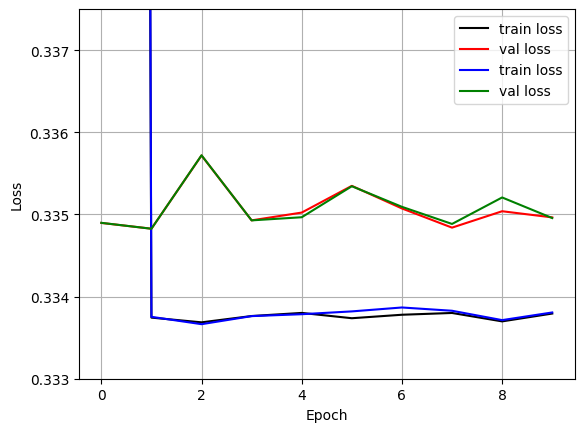

In [249]:
train_loss = np.load('saved_models/type0_batchsize64_rng42_epoch10_v0/train_loss.npy')
val_loss = np.load('saved_models/type0_batchsize64_rng42_epoch10_v0/val_loss.npy')
train_loss1 = np.load('saved_models/type0_batchsize64_rng42_epoch10_v1/train_loss.npy')
val_loss1 = np.load('saved_models/type0_batchsize64_rng42_epoch10_v1/val_loss.npy')
epochs = np.arange(len(train_loss))
plt.figure()
plt.plot(epochs,train_loss,'k',label='train loss')
plt.plot(epochs,val_loss,'r',label='val loss')
plt.plot(epochs,train_loss1,'b',label='train loss')
plt.plot(epochs,val_loss1,'g',label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim(0.333,0.3375)
plt.show()

Concatenate the parts of the input layer to make sure that real and imaginary parts of W_RF @ y are the same as the real and imaginary parts of the combined signal y after the first network layer

In [208]:
np.random.seed(2024)
y = np.random.rand(N) + 1j*np.random.rand(N)

temp = np.concatenate((w_1_in,-w_2_in),axis=1)
temp1 = np.concatenate((w_2_in,w_1_in),axis=1)
W_IN = np.concatenate((temp,temp1),axis=0)

# classic network
y_in = np.concatenate((y.real,y.imag))
fc1_input = W_IN @ y_in

# derived input
y1 = W_RF @ y
fc1_input1 = np.concatenate((y1.real,y1.imag))
print(fc1_input-fc1_input1)

[-2.22044605e-16 -5.55111512e-16 -6.10622664e-16  1.11022302e-16
 -5.41233725e-16  2.22044605e-16  2.22044605e-16  8.88178420e-16
  0.00000000e+00  1.77635684e-15  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.77635684e-15  0.00000000e+00  1.77635684e-15]


(8,)


(8, 128)

In [110]:
# Reproducibility
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
torch.backends.cudnn.deterministic = True

# PyTorch GPU/CPU selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural network
model = models[data_type]()

# Training Settings
model.to(device)
criterion = torch.nn.MSELoss() # Training Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loss = np.zeros((epochs))
train_acc = np.zeros((epochs))
val_loss = np.zeros((epochs))
val_acc = np.zeros((epochs))

# Epochs
for epoch in range(epochs):
    print('Epoch %i/%i:'%(epoch+1, epochs), flush=True)
    
    train_loss[epoch] = train_loop(X_train, y_train, model, optimizer, criterion, device, batch_size=batch_size)
    val_loss[epoch] = eval_loop(X_val, y_val, model, criterion, device, batch_size=batch_size)
    
    # Save the best model
    if val_loss[epoch] <= np.min(val_loss[:epoch] if epoch>0 else val_loss[epoch]):
        #print('Saving model..')
        torch.save(model.state_dict(), os.path.join(model_directory, 'model_best.pth'))
        
    scheduler.step()

torch.save(model.state_dict(), os.path.join(model_directory, 'model_final.pth'))

print('Finished Training')

Epoch 1/500:
  0%|          | 0/1 [00:00<?, ? batch/s]

RuntimeError: mat1 and mat2 must have the same dtype